# Visualizing RST structures in GeM corpora

This Jupyter notebook is intended for visualizing discourse structures in multimodal documents, as described using <a href="http://www.sfu.ca/rst/">Rhetorical Structure Theory</a> and annotated using the schema proposed in the <a href="http://www.fb10.uni-bremen.de/anglistik/langpro/projects/gem/newframe.html">Genre and Multimodality</a> model.

For visualizing the RST structures, you need valid XML files for both base and RST layers. The content is retrieved from the base layer, before drawing out the rhetorical relations between the content, as defined in the RST annotation.

The notebook adopts the technique proposed in Thomas (2009) for representing RST structures using Graphviz DOT, originally implemented in Perl and rewritten in XQuery as a part of Hiippala (2013). The RST relations ("spans") are represented using DOT nodes. Relations are drawn as edges from both nuclei and satellite nodes ("segments") towards the span, thus creating a hierarchical structure suitable for representing RST structures.

**References**

Hiippala, T. (2013) *Modelling the structure of a multimodal artefact*. PhD thesis, University of
Helsinki. https://helda.helsinki.fi/handle/10138/41736

Thomas, M. (2009) *Localizing pack messages: A framework for corpus-based cross-cultural
multimodal analysis*. PhD thesis, University of Leeds.

## 1. Import the necessary packages.

In [1]:
# For parsing XML
from lxml import etree as et

# For formatting the content
import textwrap
import codecs

# For displaying the results in the notebook
from IPython.display import Image

Check GraphViz installation.

In [2]:
graphviz_installed = !which dot
if graphviz_installed == '':
    print "Graphviz/DOT not found. Exiting ..."
    quit()
else:
    print "Graphviz/DOT found ..."

Graphviz/DOT found ...


## 2. Parse the GeM XML files.

Define the base and RST files below.

In [3]:
basefile = 'test_xml/1980-tgh-base-1.xml' # Base layer
rstfile = 'test_xml/1980-tgh-rst-1.xml' # RST layer

Define a function to parse base and RST files.

In [4]:
def parse_base(basefile, rstfile):
    base_units = {} # Set up a dictionary for the base units
    baseroot = et.parse(basefile).getroot() # Parse the XML file and get XML root
    for unit in baseroot.findall('.//unit'):
        unit_id = unit.attrib['id']
        if 'alt' in unit.attrib:
            unit_content = unit.attrib['alt'], ', fontsize="12.0", shape="box"];\n'
        else:
            unit_content = textwrap.fill(''.join(unit.itertext()), 35).replace("\"", "'"), ', fontsize="12.0", shape="box", style="filled", color="white"];\n'
        base_units[unit_id] = unit_content # Populate dictionary with key (id) and value (content) pairs
            
    rst_segments = {} # Set up a dictionary for the RST units
    rstroot = et.parse(rstfile).getroot()
    
    for rst_segment in rstroot.findall('.//segment'):
        rst_segment_id, rst_segment_xref = rst_segment.attrib['id'], rst_segment.attrib['xref']
        rst_segment_content = base_units[rst_segment_xref]
        rst_segments[rst_segment_id] = rst_segment_content
        
    for mini_segment in rstroot.findall('.//mini-segment'):
        mini_segment_id, mini_segment_xref = mini_segment.attrib['id'], mini_segment.attrib['xref']
        mini_segment_content = base_units[mini_segment_xref]
        rst_segments[mini_segment_id] = mini_segment_content
            
    rst_relations = {}

    for rst_structure in rstroot.findall('rst-structure'):
        for span in rst_structure.getchildren():
            rst_relations[span.attrib['id']] = span.attrib['relation'].upper(), ', fontcolor="crimson", fontsize="10.0", shape="plaintext"];\n'
       
    return rst_segments, rst_relations, rstroot

In [5]:
rst_segments, rst_relations, rstroot = parse_base(basefile, rstfile)

## 3. Draw the RST graph.

Open a file for the graph; use UTF-8 encoding. Set up the beginning and the end of the graph.

In [6]:
graph = codecs.open('rst_graph.gv', 'w', 'utf-8')

begin_graph = 'digraph "rstgraph" { graph [rankdir="BT"];\n'
terminate_graph = '}'

Begin writing the graph.

In [7]:
# Print the DOT graph preamble
# print begin_graph
graph.write(begin_graph)

# Add RST spans to the graph
for span in sorted(rst_relations):
    relation, style = rst_relations.get(span)
    print_span = '"', span, '"\t[label="', relation, '"', style
    graph.write("".join(print_span))
    
# Add RST segments to the graph
for node in sorted(rst_segments):
    content, style = rst_segments.get(node)
    print_node = '"', node, '"\t[label="', content, '"', style
    graph.write("".join(print_node))
            
# Add edges
for span in rstroot.findall('.//rst-structure/*'):
    if span.tag == 'multi-span':
        multispan, nuclei = span.attrib['id'], span.attrib['nuclei'].split()
        if span.attrib['id'] == multispan:
            for n in nuclei:
                print_nuclei = '"', n, '" -> ', '"', multispan, '"\t [dir="back"];\n'
                graph.write("".join(print_nuclei))

    if span.tag == 'span':
        spanid, nucleus, satellites = span.attrib['id'], span.attrib['nucleus'].split(), span.attrib['satellites'].split()
        if span.attrib['id'] == spanid:
            for n in nucleus:
                print_nucleus = '"', n, '" -> ', '"', spanid, '"\t [dir="back"];\n'
                graph.write("".join(print_nucleus))
            for s in satellites:
                print_satellites = '"', s, '" -> ', '"', spanid, '"\t [dir="none"];\n'
                graph.write("".join(print_satellites))
                
    if span.tag == 'mini-span':
        spanid, attribuend, attribute = span.attrib['id'], span.attrib['attribuend'].split(), span.attrib['attribute'].split()
        if span.attrib['id'] == spanid:
            for atb in attribuend:
                print_attribuend = '"', atb, '" -> ', '"', spanid, '"\t [dir="back"];\n'
                graph.write("".join(print_attribuend))       
            for att in attribute:
                print_attribute = '"', att, '" -> ', '"', spanid, '"\t [dir="none"];\n'
                graph.write("".join(print_attribute))                
        
    for title in span.iter('title'):
        target_id = span.attrib['id']
        title_xref = title.attrib['xref']
        if span.attrib['id'] == target_id:
            print_title = '"', title_xref, '" -> ', '"', target_id, '"\t [dir="none", style="dashed"];\n'
            graph.write("".join(print_title))

graph.write(terminate_graph)

Close the graph file.

In [8]:
graph.close()

Use DOT draw the graph.

In [9]:
!dot -Tpng rst_graph.gv > rst_graph.png

Show the resulting image in the Jupyter notebook.

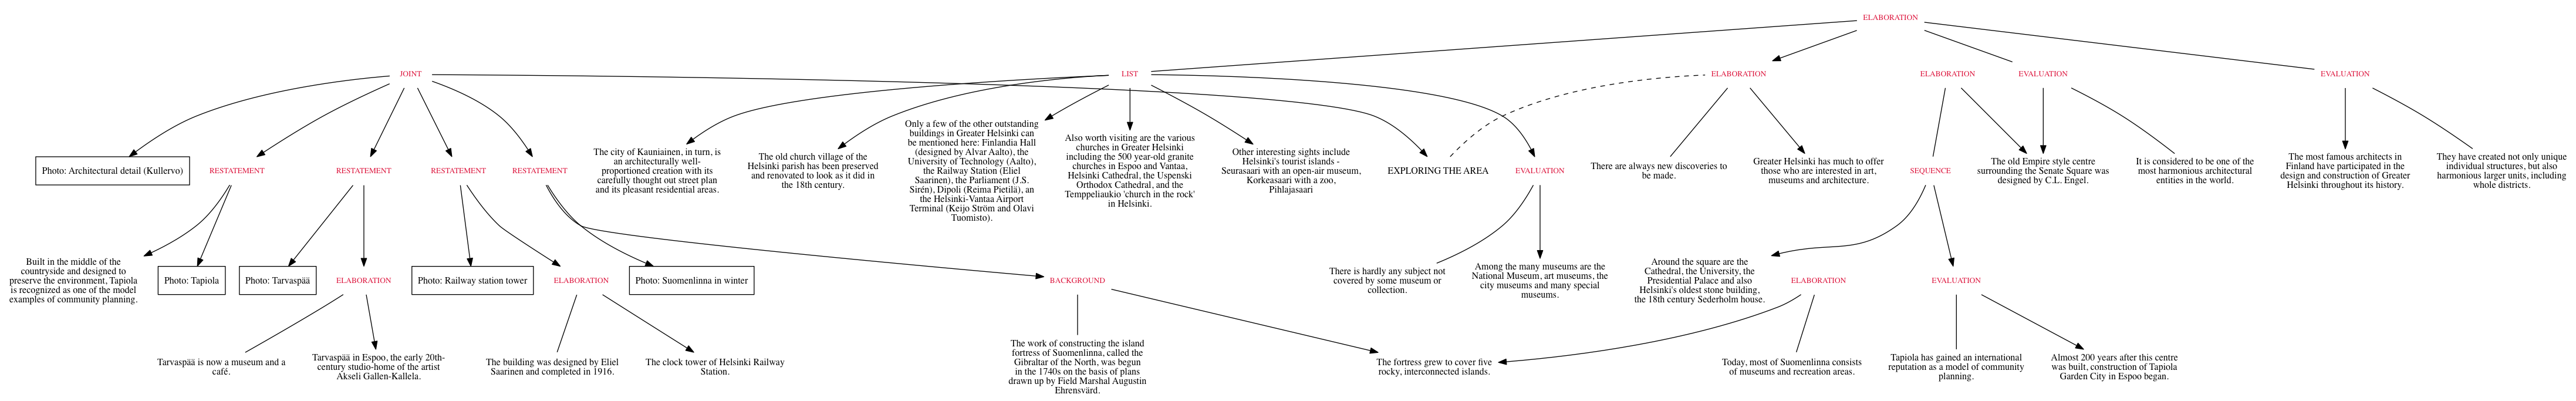

In [10]:
Image('rst_graph.png')